# Bay Area Bikeshare Analysis

<img src="https://cdn.vox-cdn.com/thumbor/3VnR0Pfoyz7NIGS1XU59FgV61ok=/0x0:3000x2000/1720x0/filters:focal(0x0:3000x2000):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/11953347/969820572.jpg.jpg">
Image Source: https://cdn.vox-cdn.com

**Ford GoBike** is trying to find ways to increase ridership and in order to do so, is looking for recommendations for deals that can be offered through its mobile app. In order to come up with recommendations, I analyzed the **Bay Area Bike Share** data available in https://cloud.google.com/bigquery/public-data/bay-bike-share. The dataset consists of three main tables:
- bikeshare_stations $\hspace{5pt}$ - $\hspace{5pt}$ This table has data related to the stations, their location, count of docks and installation date.
- bikeshare status $\hspace{12pt}$ - $\hspace{5pt}$ This table has data related to the availability of bikes and docks and the corresponding times.
- bikeshare_trips $\hspace{16pt}$ - $\hspace{5pt}$ This table has data related to the trips and the subscribers/customers using the bikes.

I also used the following external dataset to get a better idea of the existing bikeshare landscape:
- ZipCode data - A database of US zip codes was downloaded from https://simplemaps.com/data/us-zips. Only the zip, city and state columns were used from this dataset. The city and state columns have data for the respective official USPS city name and state corresponding to the zip.

In order to get an understanding of the data quality as well as to highlight insights gained from the data, I started off by analyzing the above datasets and carrying out an exploratory data analysis (EDA). During the analysis, I also created some intermediate datasets to allow storage and use of pre-calculated fields as well as aggregated data. This notebook is an attempt to present the highlights of the analysis along with discussions on the findings and the inferences made thereof. I then attempted to identify the 5 most popular "commuter trips" based on some assumptions related to commuter trips and the insights gained from the EDA. At the end I made a few recommendations for offers that can potentially help Ford GoBike to increase ridership. 

## Dataset Stats
- How may trips are there in the dataset?

In [5]:
!bq query --use_legacy_sql=FALSE ' \
select count(distinct trip_id) as trip_count FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r647717add9431c56_00000166425928e1_1 ... (1s) Current status: DONE   
+------------+
| trip_count |
+------------+
|     983648 |
+------------+


- How many stations are accounted for in the dataset?

In [6]:
!bq query --use_legacy_sql=FALSE ' \
select count(distinct station_id) as station_count FROM `bigquery-public-data.san_francisco.bikeshare_stations`'

Waiting on bqjob_rc208f3dc4d4704a_00000166425bbdcf_1 ... (0s) Current status: DONE   
+---------------+
| station_count |
+---------------+
|            74 |
+---------------+


- How many bikes are there?

In [7]:
!bq query --use_legacy_sql=FALSE ' \
SELECT count(distinct bike_number) as bike_count FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r6c853e3d3011b43a_00000166425f76e4_1 ... (0s) Current status: DONE   
+------------+
| bike_count |
+------------+
|        700 |
+------------+


- What is the total number of zip codes for the current customer base? 

In [8]:
!bq query --use_legacy_sql=FALSE ' \
SELECT count(distinct zip_code) as zip_count FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r6eb6789706933da8_0000016642629f98_1 ... (0s) Current status: DONE   
+-----------+
| zip_count |
+-----------+
|      8830 |
+-----------+


- How many cities with bikeshare stations are considered the dataset?

In [10]:
!bq query --use_legacy_sql=FALSE ' \
SELECT count(distinct landmark) as city_count FROM `bigquery-public-data.san_francisco.bikeshare_stations`'

Waiting on bqjob_r107575e28e170350_00000166426349f4_1 ... (0s) Current status: DONE   
+------------+
| city_count |
+------------+
|          5 |
+------------+


## Data Preparation

I created the following datasets in google big query:
- <a href="https://bigquery.cloud.google.com/table/strange-song-215316:bike_trip_data.bikeshare_status_details?pli=1">bikeshare_status_details</a> - This dataset has additional columns for various date and time breakups on top of the base columns available in the *bikeshare_status* table
- <a href="https://bigquery.cloud.google.com/table/strange-song-215316:bike_trip_data.bikeshare_sts_mth_summary?pli=1">bikeshare_sts_mth_summary</a> - This dataset has aggregated *bikeshare_status* data at the month level
- <a href="https://bigquery.cloud.google.com/table/strange-song-215316:bike_trip_data.bikeshare_sts_day_summary?pli=1">bikeshare_sts_day_summary </a> - This dataset has aggregated *bikeshare_status* data at the day level
- <a href="https://bigquery.cloud.google.com/table/strange-song-215316:bike_trip_data.bikeshare_sts_weekday_summary?pli=1">bikeshare_sts_weekday_summary </a> - This dataset has aggregated *bikeshare_status* data at the 'day of week' level
- <a href="https://bigquery.cloud.google.com/table/strange-song-215316:bike_trip_data.bikeshare_sts_hour_summary?pli=1">bikeshare_sts_hour_summary </a> - This dataset has aggregated *bikeshare_status* data at the hour level
- <a href="https://bigquery.cloud.google.com/table/strange-song-215316:bike_trip_data.bikeshare_trip_details?pli=1">bikeshare_trip_details</a> - This dataset has additional columns for categorizing one-way vs round trips, trip times as well as various date and time breakups on top of the base columns available in the *bikeshare_trips* table. Trips with the same start and end station name are categorized as *'Round Trips'* while the others are *'One Way Trips'*. Trips starting between 2 AM and 5 AM are categorized as *'Early Morning Trips'*, trips starting between 5 AM and noon as *'Morning Trips'*, trips starting between noon and 5 PM as *'Afternoon Trips'*, trips starting between 5 PM and 10 PM as *'Evening Trips'* and trips starting between 10 PM and 2 AM are categorized as *'Night Trips'*.

The queries used to create these datasets is provided in the Appendix in the last section of the notebook.

#### Query Big Query Datasets and Write data to csv files

**Note:** The csv files have been written to the folder for assignment 04 in the droplet. The csv files have not been uploaded to git due to the size of the files.

In [12]:
# Bikeshare Stations
! bq query --use_legacy_sql=FALSE --format=csv ' \
SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_stations`' > bike_stn.csv

Waiting on bqjob_r468ac1f56b8fa3aa_0000016642765650_1 ... (0s) Current status: DONE   

In [7]:
# Bikeshare Status Summaries
! bq query --use_legacy_sql=FALSE --max_rows 1000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_sts_mth_summary`' > bike_sts_mth.csv
! bq query --use_legacy_sql=FALSE --max_rows 2500 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_sts_day_summary`' > bike_sts_day.csv
! bq query --use_legacy_sql=FALSE --max_rows 550 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_sts_weekday_summary`' > bike_sts_wkday.csv
! bq query --use_legacy_sql=FALSE --max_rows 2000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_sts_hour_summary`' > bike_sts_hr.csv

Waiting on bqjob_r55e704c60b4950e6_000001664fac766f_1 ... (0s) Current status: DONE   

In [17]:
# Bikeshare Trip Details - Queries broken down by trip month to account for the limitation on the number of rows
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Jan"' > bike_trp_dtls_jan.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Feb"' > bike_trp_dtls_feb.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Mar"' > bike_trp_dtls_mar.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Apr"' > bike_trp_dtls_apr.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="May"' > bike_trp_dtls_may.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Jun"' > bike_trp_dtls_jun.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Jul"' > bike_trp_dtls_jul.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Aug"' > bike_trp_dtls_aug.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Sep"' > bike_trp_dtls_sep.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Oct"' > bike_trp_dtls_oct.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Nov"' > bike_trp_dtls_nov.csv
! bq query --use_legacy_sql=FALSE --max_rows 100000 --format=csv ' \
SELECT * FROM `strange-song-215316.bike_trip_data.bikeshare_trip_details` where trip_month="Dec"' > bike_trp_dtls_dec.csv

Waiting on bqjob_r5ea2c60fa5753dc6_00000166472852df_1 ... (2s) Current status: DONE   

#### Read data from csv into dataframes

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
#Dictionary for numbering days of week
weekdays = {'Sun': 1, 'Mon': 2, 'Tue': 3, 'Wed': 4, 'Thu': 5, 'Fri': 6, 'Sat': 7}

In [3]:
#External zipcode data
df_zip = pd.read_csv('zip.csv', encoding='latin_1', usecols=['zip','city','state'])
df_zip.columns = ['zip_code','zip_city','zip_state']     #Rename columns
df_zip['zip_code'] = df_zip['zip_code'].astype(str)      #Change datatype for zip_code column
df_zip.head()

,zip_code,zip_city,zip_state
0,501,Holtsville,NY
1,544,Holtsville,NY
2,601,Adjuntas,PR
3,602,Aguada,PR
4,603,Aguadilla,PR


In [4]:
# Bikeshare Stations
df_bike_stns = pd.read_csv("bike_stn.csv")

In [5]:
# Bikeshare Status Summaries
df_bike_sts_mth = pd.read_csv("bike_sts_mth.csv")
df_bike_sts_day = pd.read_csv("bike_sts_day.csv")
df_bike_sts_wkday = pd.read_csv("bike_sts_wkday.csv")
df_bike_sts_hr = pd.read_csv("bike_sts_hr.csv")

#Add column for sorting day of week column
df_bike_sts_wkday['day_srt']=df_bike_sts_wkday.clndr_day_of_week.apply(lambda x: weekdays[x])

In [6]:
# Combine Trip Details data into a single dataframe
df_trp_dtls = pd.read_csv("bike_trp_dtls_jan.csv").append(pd.read_csv("bike_trp_dtls_feb.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_mar.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_apr.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_may.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_jun.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_jul.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_aug.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_sep.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_oct.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_nov.csv"), ignore_index=True)
df_trp_dtls = df_trp_dtls.append(pd.read_csv("bike_trp_dtls_dec.csv"), ignore_index=True)

In [7]:
#Add a column for duration in minutes
df_trp_dtls['duration_min'] = df_trp_dtls.duration_sec/60
#Add a constant column for ease in calculations
df_trp_dtls['rec_ct'] = 1

In [8]:
#Merge external zip code data with trip details
df_trp_dtls['zip_code'] = df_trp_dtls['zip_code'].astype(str)
df_trp_dtls = df_trp_dtls.merge(df_zip, how='left')

In [9]:
#Add columns to flag if city and state for the zip are San Francisco and California respectively
df_trp_dtls['local_city'] = df_trp_dtls['zip_city'].apply(lambda x: 1 if x=='San Francisco' else 0)
df_trp_dtls['local_state'] = df_trp_dtls['zip_state'].apply(lambda x: 1 if x=='CA' else 0)

#Add sorting column for df_bike_sts_wkday
df_trp_dtls['day_srt']=df_trp_dtls.trip_day_of_week.apply(lambda x: weekdays[x])

## Exploratory Data Analysis

### Bikeshare Stations

In [10]:
df_bike_stns.head()

,station_id,name,latitude,longitude,dockcount,landmark,installation_date
0,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
1,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09
2,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,2013-08-05
3,9,Japantown,37.348742,-121.894715,15,San Jose,2013-08-05
4,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-05


In [11]:
df_bike_stns[['station_id', 'dockcount']].describe()

,station_id,dockcount
count,74.000000,74.000000
mean,45.513514,18.162162
std,25.770985,4.634673
min,2.000000,11.000000
25%,25.250000,15.000000
50%,46.500000,17.000000
75%,66.750000,19.000000
max,91.000000,35.000000


This dataset has data for 74 stations. There is an average of 18 docks per station. The maximum number of docks is 35 and the minimum is 11.

In [12]:
df_bike_stns.pivot_table(index='landmark', values='installation_date', aggfunc=(min, max))

,max,min
landmark,,
Mountain View,2015-09-28,2013-08-15
Palo Alto,2013-08-15,2013-08-14
Redwood City,2014-02-20,2013-08-12
San Francisco,2016-08-04,2013-08-19
San Jose,2016-06-05,2013-08-05


An examination of the installation dates for the stations shows that the earliest stations were installed in August 2013 for all the cities. The latest installation was in San Francisco in August 2016. There hasn't been any new installations in Palo Alto since August 2013, the month when the first station was installed there. Mountain View and Redwood City also didn't have any installations since September 2015 and February 2014 respectively.

In [13]:
print("Max number of docks amongst all stations: {}"
      .format(df_bike_stns.groupby(['name']).agg({'dockcount':sum}).max()))
print("Min number of docks amongst all stations: {}"
      .format(df_bike_stns.groupby(['name']).agg({'dockcount':sum}).min()))

Max number of docks amongst all stations: dockcount    35
dtype: int64
Min number of docks amongst all stations: dockcount    11
dtype: int64


In [14]:
#Create dataframe with station id and names for use as lookup
df_stns = df_bike_stns[['station_id','name']]

**Top 5 and Bottom 5 Stations by Dockcount**

In [15]:
df_stn_dock_ct_top5 = df_bike_stns.groupby(['name']).agg({'dockcount':sum})\
                                    .sort_values("dockcount",ascending=False).head()
df_stn_dock_ct_btm5 = df_bike_stns.groupby(['name']).agg({'dockcount':sum})\
                                    .sort_values("dockcount").head()

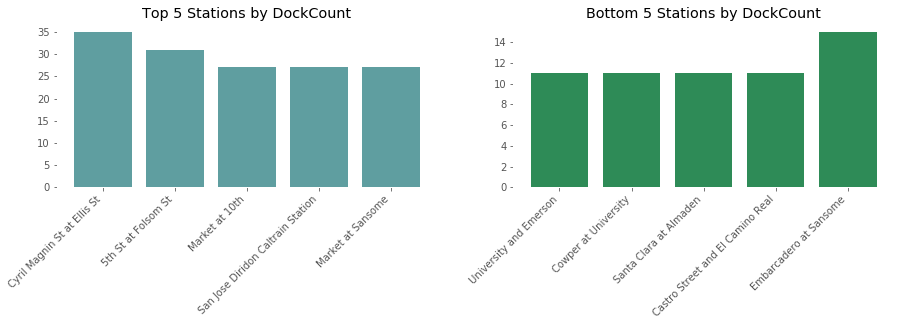

In [16]:
fig1 = plt.figure(figsize=(15,3))
plt.subplot(121, facecolor='white')
plt.title("Top 5 Stations by DockCount")
plt.xticks(rotation=45, ha='right')
plt.bar(df_stn_dock_ct_top5.index, df_stn_dock_ct_top5.dockcount, color='cadetblue')
plt.subplot(122, facecolor='white')
plt.title("Bottom 5 Stations by DockCount")
plt.xticks(rotation=45, ha='right')
plt.bar(df_stn_dock_ct_btm5.index, df_stn_dock_ct_btm5.dockcount, color='seagreen')
plt.show()

**Number of Stations and Docks by City**

In [17]:
df_bike_city_stn_ct = pd.DataFrame(df_bike_stns['landmark'].value_counts())
df_bike_city_dock_ct = df_bike_stns.groupby(['landmark']).agg({'dockcount':sum})

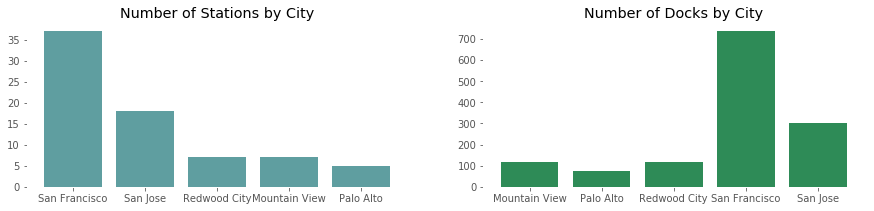

In [18]:
fig2 = plt.figure(figsize=(15,3))
plt.subplot(121, facecolor='white')
plt.title("Number of Stations by City")
plt.bar(df_bike_city_stn_ct.index, df_bike_city_stn_ct.landmark, color='cadetblue')
plt.subplot(122, facecolor='white')
plt.title("Number of Docks by City")
plt.bar(df_bike_city_dock_ct.index, df_bike_city_dock_ct.dockcount, color='seagreen')
plt.show()

### Bikeshare Station Status

Next I analyzed the bikeshare status data to understand the nature of the availability of bikes and docks for various stations by month, day, day of week and hour. This should give an idea of the demand of bikes for the various stations by these date and time splits.

In [19]:
#Analyze monthly summary
df_bike_sts_mth = df_bike_sts_mth.merge(df_stns, how='left')

In [20]:
#Least popular stations
#Find 3 max values for unused_pct for any given month for any given station
max_unused_bikes = list(np.sort(df_bike_sts_mth.unused_pct.unique())[-3:])
#Find the stations with the least usage for a given month, i.e. the ones matching the unused_pct above
df_bike_sts_mth[df_bike_sts_mth.unused_pct.isin(max_unused_bikes)] \
            .pivot_table(index=['station_id','name'], values='unused_pct', columns=['clndr_month_num','clndr_month'], fill_value='')

,clndr_month_num,2,4,5,6,8,10,11
,clndr_month,Feb,Apr,May,Jun,Aug,Oct,Nov
station_id,name,,,,,,,
22,Redwood City Caltrain Station,22.22,22.22,,,,,
23,San Mateo County Center,,,26.67,26.67,,,
24,Redwood City Public Library,26.67,,,,,,
36,California Ave Caltrain Station,,,,,,33.33,
38,Park at Olive,,,,,26.67,,
83,Mezes Park,,,,,,,26.67


On inspecting the least usage by month, I found that Feb has the least usage for two of the stations. It may be worthwhile to run some promotions for these stations in Feb of each year. It may also be worthwhile to check if there is something specific for the other month and station combinations that results in the least usage.

In [21]:
#Analyze day of week summary
df_bike_sts_wkday = df_bike_sts_wkday.merge(df_stns, how='left')
#Find 3 max values for unused_pct for any given day of week for any given station
max_unused_bikes = list(np.sort(df_bike_sts_wkday.unused_pct.unique())[-3:])
#Find the stations with the least usage for a given day of week, i.e. the ones matching the unused_pct above
df_bike_sts_wkday[df_bike_sts_wkday.unused_pct.isin(max_unused_bikes)] \
            .pivot_table(index=['station_id','name'], values='unused_pct', columns=['day_srt','clndr_day_of_week'], fill_value='')

,day_srt,1,2,3,5,6,7
,clndr_day_of_week,Sun,Mon,Tue,Thu,Fri,Sat
station_id,name,,,,,,
88,5th S. at E. San Salvador St,47.37,47.37,47.37,47.37,47.37,47.37
89,S. Market st at Park Ave,,,31.58,,,
90,5th St at Folsom St,64.52,,,,,64.52


The station '5th S. at E. San Salvador St' has low usage for all days of the week. '5th St at Folsom St' has less than 40% usage on weekends while 'S. Market st at Park Ave' has very low usage on Tuesdays.

In [22]:
#Analyze hour of day summary
df_bike_sts_hr = df_bike_sts_hr.merge(df_stns, how='left')
#Find 3 max values for unused_pct for any given hour of day for any given station
max_unused_bikes = list(np.sort(df_bike_sts_hr.unused_pct.unique())[-3:])
#Find the stations with the least usage for a given hour of day, i.e. the ones matching the unused_pct above
df_bike_sts_hr[df_bike_sts_hr.unused_pct.isin(max_unused_bikes)] \
            .pivot_table(index=['station_id','name'], values='unused_pct', columns='hour_of_day', fill_value='')

,hour_of_day,0,1,2,3,4,5,6,18,19
station_id,name,,,,,,,,,
88,5th S. at E. San Salvador St,47.37,47.37,47.37,47.37,47.37,47.37,47.37,,
90,5th St at Folsom St,,,,,,,,45.16,51.61


The station at '5th S. at E. San Salvador St' has the least usage during the early hours of the day while '5th St at Folsom St' is the least used station a couple of hours in the evening.

### Bikeshare Trips

In [23]:
#Drop the columns that will not be used in the analysis
df_trp_dtls.drop(['duration_sec', 'bike_number'], axis=1, inplace=True)
df_trp_dtls.head()

,trip_id,start_datetime,start_station_name,start_station_id,end_datetime,end_station_name,end_station_id,zip_code,subscriber_type,start_date,...,end_time,trip_type,trip_time,duration_min,rec_ct,zip_city,zip_state,local_city,local_state,day_srt
0,140012,2014-01-01 23:26:00,St James Park,13,2014-01-02 00:24:00,St James Park,13,95051,Customer,01/01/14,...,00:24:00,RoundTrip,Night,58.916667,1,Santa Clara,CA,0,1,4
1,140013,2014-01-01 23:26:00,St James Park,13,2014-01-02 00:24:00,St James Park,13,nan,Customer,01/01/14,...,00:24:00,RoundTrip,Night,58.650000,1,NaN,NaN,0,0,4
2,139589,2014-01-01 02:21:00,Howard at 2nd,63,2014-01-01 16:51:00,2nd at Townsend,61,94107,Customer,01/01/14,...,16:51:00,OneWayTrip,Night,870.383333,1,San Francisco,CA,1,1,4
3,139588,2014-01-01 02:18:00,Howard at 2nd,63,2014-01-01 16:51:00,2nd at Townsend,61,94107,Customer,01/01/14,...,16:51:00,OneWayTrip,Night,873.250000,1,San Francisco,CA,1,1,4
4,139591,2014-01-01 02:24:00,Howard at 2nd,63,2014-01-01 14:14:00,2nd at Townsend,61,94107,Customer,01/01/14,...,14:14:00,OneWayTrip,Night,710.283333,1,San Francisco,CA,1,1,4


In [24]:
df_trp_dtls.describe()

,trip_id,start_station_id,end_station_id,trip_year,trip_month_num,trip_day_num,trip_hour,duration_min,rec_ct,local_city,local_state,day_srt
count,9.836480e+05,983648.000000,983648.000000,983648.00000,983648.000000,983648.00000,983648.000000,983648.000000,983648.0,983648.000000,983648.000000,983648.000000
mean,6.721238e+05,58.121022,58.100089,2014.67776,6.502639,15.68426,13.031849,16.982206,1.0,0.450699,0.915522,3.999283
std,3.851056e+05,16.841133,16.912386,0.92242,3.268243,8.67432,4.553469,306.947284,0.0,0.497564,0.278104,1.652424
min,4.069000e+03,2.000000,2.000000,2013.00000,1.000000,1.00000,0.000000,1.000000,1.0,0.000000,0.000000,1.000000
25%,3.359168e+05,50.000000,50.000000,2014.00000,4.000000,8.00000,9.000000,5.783333,1.0,0.000000,1.000000,3.000000
50%,6.779755e+05,62.000000,62.000000,2015.00000,7.000000,16.00000,13.000000,8.633333,1.0,0.000000,1.000000,4.000000
75%,1.001672e+06,70.000000,70.000000,2015.00000,9.000000,23.00000,17.000000,12.466667,1.0,1.000000,1.000000,5.000000
max,1.338408e+06,91.000000,91.000000,2016.00000,12.000000,31.00000,23.000000,287840.000000,1.0,1.000000,1.000000,7.000000


This dataset has data for 983648 trips. The data covers trips from April 2014 to December 2016. The trips in the dataset have a maximum duration of 287840 minutes which is roughly equal to 200 days. So it appears that there is some data issue in the duration values that warrants further investigation. The minimum duration of the trips is around 1 minute and the average duration is about 17 minutes. 

In [25]:
df_trp_dtls[df_trp_dtls.duration_min==287840.000000]

,trip_id,start_datetime,start_station_name,start_station_id,end_datetime,end_station_name,end_station_id,zip_code,subscriber_type,start_date,...,end_time,trip_type,trip_time,duration_min,rec_ct,zip_city,zip_state,local_city,local_state,day_srt
926464,568474,2014-12-06 21:59:00,South Van Ness at Market,66,2015-06-24 20:18:00,2nd at Folsom,62,95531,Customer,12/06/14,...,20:18:00,OneWayTrip,Evening,287840.0,1,Crescent City,CA,0,1,7


The record having a trip duration of 287840 minutes is related to a Customer living in Crescent City CA. The trip started in December 2014 from South Van Ness at Market station. The validity of the duration data of this record is questionable and should be omitted from any analysis involving duration.

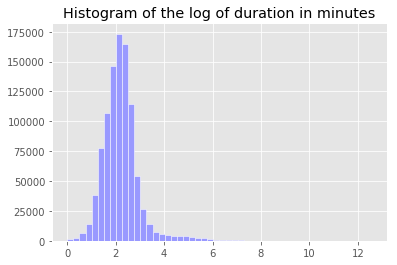

In [26]:
plt.hist(np.log(df_trp_dtls.duration_min), bins=50, facecolor='#9999ff', edgecolor='white')
plt.title("Histogram of the log of duration in minutes")
plt.show()

A plot of the histogram of the log of duration in minutes shows a definite right skew in the data. This shows that bikes are in general used for short trips.

In [27]:
print("Percent of records with duration within an hour: {}".format(round(100*(df_trp_dtls[df_trp_dtls.duration_min < 60]
                                                                                 .trip_id.count()/df_trp_dtls.trip_id.count()),2)))
print("Percent of records with duration more than 3 hours: {}".format(round(100*(df_trp_dtls[df_trp_dtls.duration_min >= 180]
                                                                                 .trip_id.count()/df_trp_dtls.trip_id.count()),2)))
print("Percent of records with duration more than a day: {}".format(round(100*(df_trp_dtls[df_trp_dtls.duration_min >= 1440]
                                                                               .trip_id.count()/df_trp_dtls.trip_id.count()),2)))
print("Number of records with duration more than a day: {}".format(df_trp_dtls[df_trp_dtls.duration_min >= 1440]
                                                                     .trip_id.count()))
print("Subscriber types for riding bikes with duration more than a day: {}".format(np.unique(df_trp_dtls[df_trp_dtls.duration_min >= 1440]
      ['subscriber_type'], return_counts=True)))

Percent of records with duration within an hour: 97.14
Percent of records with duration more than 3 hours: 1.07
Percent of records with duration more than a day: 0.03
Number of records with duration more than a day: 296
Subscriber types for riding bikes with duration more than a day: (array(['Customer', 'Subscriber'], dtype=object), array([248,  48]))


Further investigation of the trip_duration records show that roughly 97% of the trips have a duration of less than an hour and only about 1% of the trips have a duration more than 3 hours and about 0.03% have duration more than a day. The trips spanning multiple days are not restricted to any specific subscriber type. 

In [28]:
#Check how many zip codes do not have a corresponding zip_city
#If a zip code did not find a corresponding city from the external dataset
#we assume the zip code to be invalid
print("Percentage of invalid zip codes in the dataset: {}".
      format(round(100* df_trp_dtls.zip_city.isna().values.sum()/df_trp_dtls.trip_id.count(), 2)))
print("Number of invalid zip codes for subscribers: {}".
      format(df_trp_dtls[df_trp_dtls.subscriber_type=='Subscriber'].zip_city.isna().values.sum()))
print("Number of invalid zip codes for customers: {}".
      format(df_trp_dtls[df_trp_dtls.subscriber_type=='Customer'].zip_city.isna().values.sum()))

Percentage of invalid zip codes in the dataset: 3.68
Number of invalid zip codes for subscribers: 1964
Number of invalid zip codes for customers: 34189


Analysis of the zip code data shows that about 3% records in the dataset appear to have invalid zip codes. Of the invalid zip codes, most are related to customer records. This should not have any impact on any analysis done based on zip code.

**Subscriber Type Analysis**

In [29]:
#Subscriber trip data
df_trp_dtls_subs = df_trp_dtls[df_trp_dtls.subscriber_type=='Subscriber']
#Customer trip data
df_trp_dtls_cust = df_trp_dtls[df_trp_dtls.subscriber_type=='Customer']

print("Number of subscriber related trips: {}".format(df_trp_dtls_subs.trip_id.count()))
print("Number of customer related trips: {}".format(df_trp_dtls_cust.trip_id.count()))

Number of subscriber related trips: 846839
Number of customer related trips: 136809


In [30]:
#Month level aggregation
df_trp_mth_subs = df_trp_dtls_subs.pivot_table(index=['trip_month_num','trip_month'],
                                          values='rec_ct',aggfunc=sum).reset_index()
df_trp_mth_cust = df_trp_dtls_cust.pivot_table(index=['trip_month_num','trip_month'],
                                          values='rec_ct',aggfunc=sum).reset_index()
#Day level aggregation
df_trp_day_subs = df_trp_dtls_subs.pivot_table(index='trip_day_num',values='rec_ct',aggfunc=sum)
df_trp_day_cust = df_trp_dtls_cust.pivot_table(index='trip_day_num',values='rec_ct',aggfunc=sum)
#Day of Week  level aggregation
df_trp_wkdy_subs = df_trp_dtls_subs.pivot_table(index=['day_srt','trip_day_of_week']
                                                ,values='rec_ct',aggfunc=sum).reset_index()
df_trp_wkdy_cust = df_trp_dtls_cust.pivot_table(index=['day_srt','trip_day_of_week']
                                                ,values='rec_ct',aggfunc=sum).reset_index()
#Hour level aggregation
df_trp_hr_subs = df_trp_dtls_subs.pivot_table(index='trip_hour',values='rec_ct',aggfunc=sum)
df_trp_hr_cust = df_trp_dtls_cust.pivot_table(index='trip_hour',values='rec_ct',aggfunc=sum)

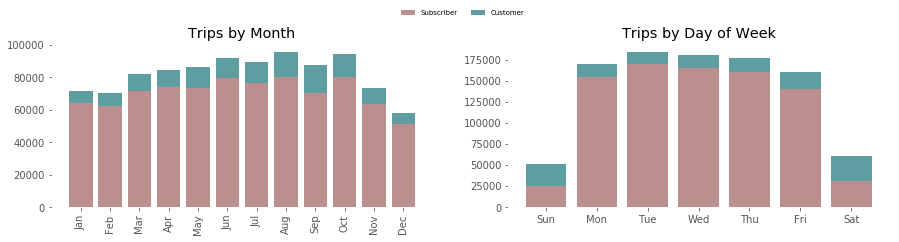

In [31]:
fig3 = plt.figure(figsize=(15,3))
plt.subplot(121, facecolor='white')
plt.title("Trips by Month")
plt.xticks(rotation=90, ha='center')
plt.bar(df_trp_mth_subs.trip_month, df_trp_mth_subs.rec_ct, color='rosybrown')
plt.bar(df_trp_mth_cust.trip_month, df_trp_mth_cust.rec_ct, color='cadetblue', bottom=df_trp_mth_subs.rec_ct)

subs = plt.Rectangle((0,0),1,1,fc="rosybrown", edgecolor = 'none')
cust = plt.Rectangle((0,0),1,1,fc='cadetblue',  edgecolor = 'none')
l = plt.legend([subs, cust], ['Subscriber', 'Customer'], loc='upper left'
               , prop={'size': 7}, ncol=2, bbox_to_anchor=(0.9, 1.25))
l.draw_frame(False)

plt.subplot(122, facecolor='white')
plt.title("Trips by Day of Week")
plt.bar(df_trp_wkdy_subs.trip_day_of_week, df_trp_wkdy_subs.rec_ct, color='rosybrown')
plt.bar(df_trp_wkdy_cust.trip_day_of_week, df_trp_wkdy_cust.rec_ct, color='cadetblue', bottom=df_trp_wkdy_subs.rec_ct)
plt.show()

The number of trips seem to be more during the middle months of the year compared to the first two and last two months. The number of trips by day of week shows a clear trend. The number of trips are much more during the weeks compared to the weekend. This is expected due to the use of bikes by commuters during the weekdays. During weekends the number of subscribers using bike share is almost proportional to the number of customers using bikeshare.

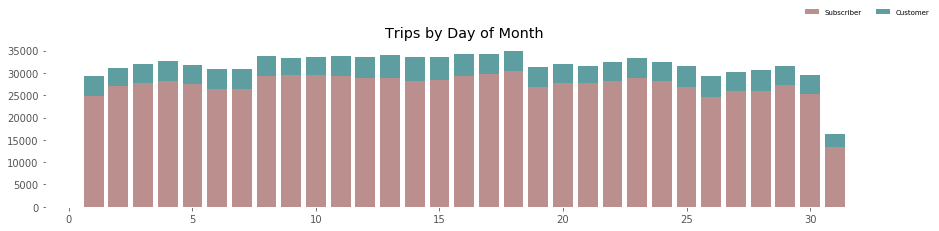

In [32]:
fig4 = plt.figure(figsize=(15,3))
plt.subplot(111, facecolor='white')
plt.title("Trips by Day of Month")
plt.bar(df_trp_day_subs.index, df_trp_day_subs.rec_ct, color='rosybrown')
plt.bar(df_trp_day_cust.index, df_trp_day_cust.rec_ct, color='cadetblue', bottom= df_trp_day_subs.rec_ct)

l = plt.legend([subs, cust], ['Subscriber', 'Customer'], loc='upper left'
               , prop={'size': 7}, ncol=2, bbox_to_anchor=(0.9, 1.25))
l.draw_frame(False)

There isn't any apparent trend in terms of the number of trips over the days of a month apart from the fact that the number of trips is slightly more between the 8th and 18th day of the month compared to the rest of the days. The dip in the 31st is due to the fact that half the months don't have 31 days.

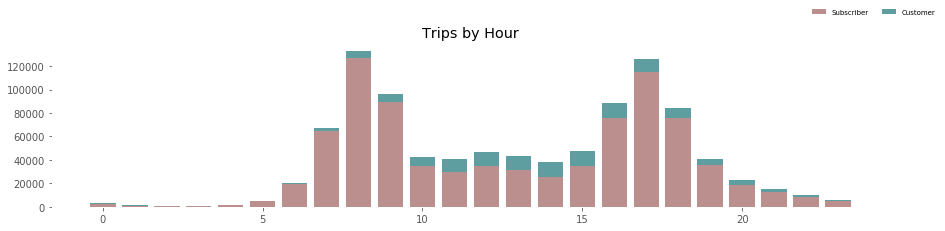

In [33]:
fig5 = plt.figure(figsize=(15,3))
plt.subplot(111, facecolor='white')
plt.title("Trips by Hour")
plt.bar(df_trp_hr_subs.index, df_trp_hr_subs.rec_ct, color='rosybrown')
plt.bar(df_trp_hr_cust.index, df_trp_hr_cust.rec_ct, color='cadetblue', bottom=df_trp_hr_subs.rec_ct)

l = plt.legend([subs, cust], ['Subscriber', 'Customer'], loc='upper left'
               , prop={'size': 7}, ncol=2, bbox_to_anchor=(0.9, 1.25))
l.draw_frame(False)

The trips by hour chart shows clear peaks during the hours of 7 AM to 10 AM and again during 4 PM to 7 PM. This is clearly due to the use of the bikes by commuters.

In [34]:
#State level aggregation
df_trp_st_subs = df_trp_dtls_subs.pivot_table(index='zip_state',
                                          values='rec_ct',aggfunc=sum).reset_index()
df_trp_st_cust = df_trp_dtls_cust.pivot_table(index='zip_state',
                                          values='rec_ct',aggfunc=sum).reset_index()

In [35]:
df_trp_st_subs.sort_values('rec_ct', ascending=False).head()

,zip_state,rec_ct
2,CA,841765
26,WA,460
10,MA,409
8,IL,372
16,NV,371


In [36]:
df_trp_st_cust.sort_values('rec_ct', ascending=False).head()

,zip_state,rec_ct
6,CA,58786
37,NY,6265
47,TX,2816
22,MA,2689
17,IL,2612


Its not surprising the most of the trips for both subscriber types are related to California. Amongst the trips related to the subscriber population, 99% are from California whereas among the trips related to customers, about 43% are from California. Lets now analyze the distribution among the states excluding California.

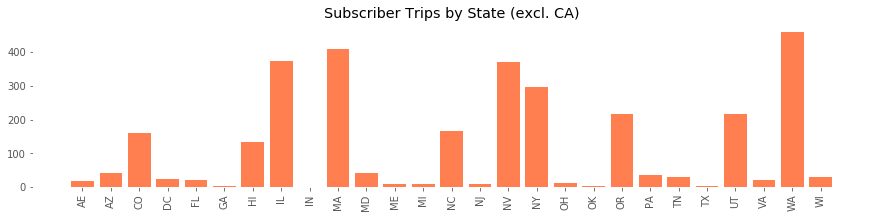

In [37]:
fig6 = plt.figure(figsize=(15,3))
plt.subplot(111, facecolor='white')
plt.title("Subscriber Trips by State (excl. CA)")
plt.bar(df_trp_st_subs[~(df_trp_st_subs.zip_state == 'CA')]
        .zip_state, df_trp_st_subs[~(df_trp_st_subs.zip_state == 'CA')].rec_ct, color='coral')
plt.xticks(rotation=90)
plt.show()

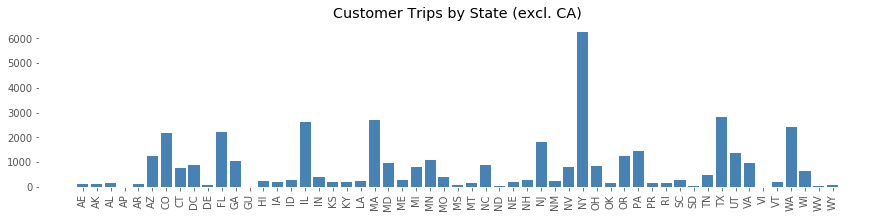

In [38]:
fig7 = plt.figure(figsize=(15,3))
plt.subplot(111, facecolor='white')
plt.title("Customer Trips by State (excl. CA)")
plt.bar(df_trp_st_cust[~(df_trp_st_cust.zip_state == 'CA')]
        .zip_state, df_trp_st_cust[~(df_trp_st_cust.zip_state == 'CA')].rec_ct, color='steelblue')
plt.xticks(rotation=90)
plt.show()

Among the trips for out of state subscribers, Washington, Massachusetts, Illinois and Nevada lead the tally. However, the number of trips for these subscriber is in mere hundreds. These could be subscribers who used to stay in California but have moved out. Among the trips for out of state customers, New York, Texas, Massachusetts and Illinois lead the tally.

In [39]:
#California Customers
df_trp_dtls_cust_CA = df_trp_dtls_cust[df_trp_dtls_cust.zip_state == 'CA']
#City Pivot for California Customers
df_trp_city_cust_CA = df_trp_dtls_cust_CA.pivot_table(index='zip_city',
                                          values='rec_ct',aggfunc=sum).reset_index().sort_values(
                                            'rec_ct', ascending=False).head(15)

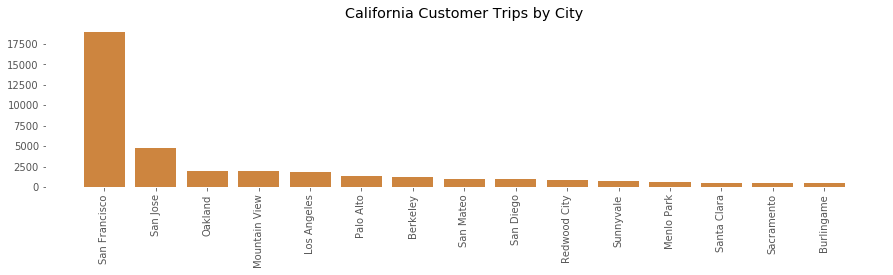

In [40]:
fig8 = plt.figure(figsize=(15,3))
plt.subplot(111, facecolor='white')
plt.title("California Customer Trips by City")
plt.bar(df_trp_city_cust_CA.zip_city, df_trp_city_cust_CA.rec_ct, color='peru')
plt.xticks(rotation=90)
plt.show()

It appears that a lot of the trips for customers from California are actually related to customers from San Francisco or nearby cities. It may be worthwhile for Ford to try and convert them to subscribers by running some promotions.

**Analyze Trips by Duration**

Earlier we found that about 97% of the trips have a duration less than an hour. These are probably commuter trips. Lets do some more analysis on these trips. We start by excluding the record which had a duration of 287840 minutes.

In [41]:
df_trp_dtls_dur = df_trp_dtls[~(df_trp_dtls.duration_min==287840.000000)]
df_trp_dtls_subs_d = df_trp_dtls_subs[~(df_trp_dtls_subs.duration_min==287840.000000)]
df_trp_dtls_cust_d = df_trp_dtls_cust[~(df_trp_dtls_cust.duration_min==287840.000000)]

In [42]:
#Dataframe for records with duration less than or equal to 2 hours
df_trp_dtls_dur2 = df_trp_dtls_dur[df_trp_dtls_dur.duration_min <=120].copy()
# Group the records with duration less than 2 hours into varying bins 
minute_ranges = [0,10,20,30,45,60,90,120]
labels = ['<=10 mins', '10-20 mins', '20-30 mins','30-45 mins','45-60 mins','60-90 mins','90-120 mins']
df_trp_dtls_dur2['min_bkt'] = pd.cut(df_trp_dtls_dur2.duration_min, minute_ranges, labels=labels).astype('category')

df_trp_dtls_dur2_pvt = df_trp_dtls_dur2.pivot_table(index='min_bkt',
                                          values='rec_ct',aggfunc=sum).reset_index()

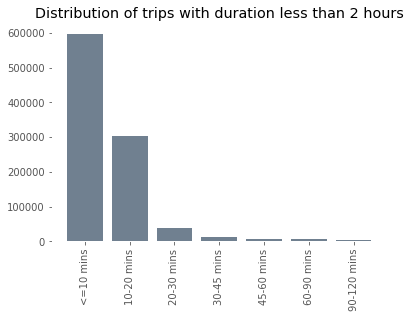

In [43]:
fig9 = plt.figure()
plt.subplot(111, facecolor='white')
plt.title("Distribution of trips with duration less than 2 hours")
plt.bar(df_trp_dtls_dur2_pvt.min_bkt, df_trp_dtls_dur2_pvt.rec_ct, color='slategrey')
plt.xticks(rotation=90)
plt.show()

Of the trips having duration less than 2 hours, about 60% of the trips have a duration less than or equal to 10 minutes, about 30% have duration between 10 and 20 minutes and the rest have duration between 20 and 120 minutes.

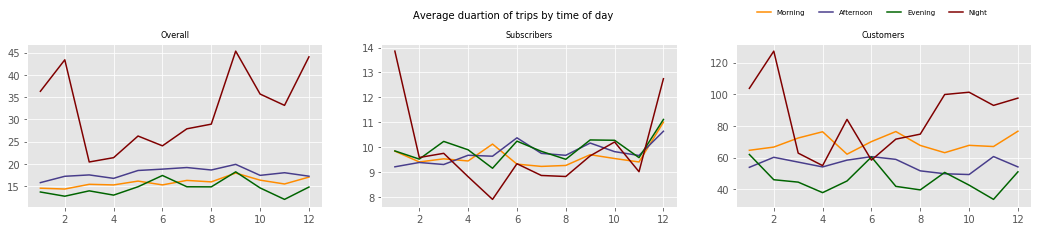

In [44]:
#Average trip duration by time of day
fig10 = plt.figure(figsize=(18,3))
fig10.text(.5, 1, "Average duartion of trips by time of day", ha='center')
plt.subplot(131)
#Overall plot
plt.plot(df_trp_dtls_dur[df_trp_dtls_dur.trip_time=='Morning'].groupby('trip_month_num')
              .duration_min.mean(), color='darkorange')
plt.plot(df_trp_dtls_dur[df_trp_dtls_dur.trip_time=='Afternoon'].groupby('trip_month_num')
              .duration_min.mean(), color='darkslateblue')
plt.plot(df_trp_dtls_dur[df_trp_dtls_dur.trip_time=='Evening'].groupby('trip_month_num')
              .duration_min.mean(), color='darkgreen')
plt.plot(df_trp_dtls_dur[df_trp_dtls_dur.trip_time=='Night'].groupby('trip_month_num')
              .duration_min.mean(), color='maroon')
plt.title("Overall", fontsize=8)

plt.subplot(132)
#Plot for subscribers
p1 = plt.plot(df_trp_dtls_subs_d[df_trp_dtls_subs_d.trip_time=='Morning'].groupby('trip_month_num')
              .duration_min.mean(), color='darkorange')
p2 = plt.plot(df_trp_dtls_subs_d[df_trp_dtls_subs_d.trip_time=='Afternoon'].groupby('trip_month_num')
              .duration_min.mean(), color='darkslateblue')
p3 = plt.plot(df_trp_dtls_subs_d[df_trp_dtls_subs_d.trip_time=='Evening'].groupby('trip_month_num')
              .duration_min.mean(), color='darkgreen')
p4 = plt.plot(df_trp_dtls_subs_d[df_trp_dtls_subs_d.trip_time=='Night'].groupby('trip_month_num')
              .duration_min.mean(), color='maroon')
plt.title("Subscribers", fontsize=8)
l = plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Morning', 'Afternoon','Evening','Night'), loc='upper left'
               , prop={'size': 7}, ncol=4, bbox_to_anchor=(1.25, 1.25))
l.draw_frame(False)

plt.subplot(133)
#plot for customers
plt.plot(df_trp_dtls_cust_d[df_trp_dtls_cust_d.trip_time=='Morning'].groupby('trip_month_num')
              .duration_min.mean(), color='darkorange')
plt.plot(df_trp_dtls_cust_d[df_trp_dtls_cust_d.trip_time=='Afternoon'].groupby('trip_month_num')
              .duration_min.mean(), color='darkslateblue')
plt.plot(df_trp_dtls_cust_d[df_trp_dtls_cust_d.trip_time=='Evening'].groupby('trip_month_num')
              .duration_min.mean(), color='darkgreen')
plt.plot(df_trp_dtls_cust_d[df_trp_dtls_cust_d.trip_time=='Night'].groupby('trip_month_num')
              .duration_min.mean(), color='maroon')
plt.title("Customers", fontsize=8)
plt.show()

Overall for all the months, the average duration of trips starting at night is usually more than the ones starting at other times of the day. The average duration of trip starting at morning, afternoon and evenings are pretty close most of the year. However, for subscribers, the duration of trips starting at night is lesser than the ones starting at other times of the day from February to November. Between February and May, the average duration of trips starting at Mornings, Afternoons and Evenings are close. However, between June and November, the average duration of trips starting in Mornings is lesser than those those starting in Afternoons and Evenings. For customers, the trips starting at night has a greater average duration than the ones starting at other times, for most of the year. Among Morning, Afternoon and Evening trips, the average duration of trips starting in mornings is the most and the ones starting in Evenings is the least throughout the year.

**Trip Type**

In [45]:
#Local trip data
df_trp_dtls_local = df_trp_dtls[df_trp_dtls.local_state==1]
#Out of state trip data
df_trp_dtls_nonlocal = df_trp_dtls[df_trp_dtls.local_state==0]

print("Number of trips related to California subscribers and customers: {}"
      .format(df_trp_dtls_local.trip_id.count()))
print("Number of trips related to subscribers and customers from other states: {}"
      .format(df_trp_dtls_nonlocal.trip_id.count()))

Number of trips related to California subscribers and customers: 900551
Number of trips related to subscribers and customers from other states: 83097


In [46]:
#Trip Type aggregation for California subscribers and customers
df_trp_trptyp_local = df_trp_dtls_local.pivot_table(index='trip_type',
                                          values='rec_ct',aggfunc=sum).reset_index()
df_trp_trptyp_local

,trip_type,rec_ct
0,OneWayTrip,880802
1,RoundTrip,19749


In [47]:
#Trip Type aggregation for non-California subscribers and customers
df_trp_trptyp_nonlocal = df_trp_dtls_nonlocal.pivot_table(index='trip_type',
                                          values='rec_ct',aggfunc=sum).reset_index()
df_trp_trptyp_nonlocal

,trip_type,rec_ct
0,OneWayTrip,70799
1,RoundTrip,12298


The number of one way trips is more for both subscriber types within California as well as the ones from the other states. However the proportion of one way trips to round trips is much higher for subscribers within California.

In [48]:
#Local trip data
df_trp_dtls_nlocal_one = df_trp_dtls_nonlocal[df_trp_dtls_nonlocal.trip_type=='OneWayTrip']
#Out of state trip data
df_trp_dtls_nlocal_rnd = df_trp_dtls_nonlocal[df_trp_dtls_nonlocal.trip_type=='RoundTrip']


df_trp_dtls_nlocal_one_pvt = df_trp_dtls_nlocal_one.pivot_table(index='subscriber_type',
                                          values='rec_ct',aggfunc=sum).reset_index()
df_trp_dtls_nlocal_rnd_pvt = df_trp_dtls_nlocal_rnd.pivot_table(index='subscriber_type',
                                          values='rec_ct',aggfunc=sum).reset_index()

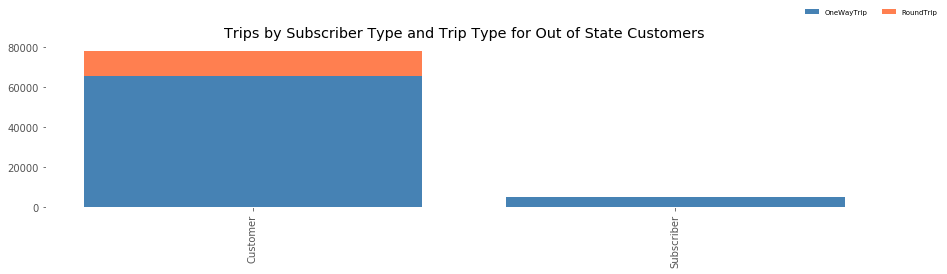

In [49]:
fig11 = plt.figure(figsize=(15,3))
plt.subplot(111, facecolor='white')
plt.title("Trips by Subscriber Type and Trip Type for Out of State Customers")
plt.xticks(rotation=90, ha='center')
plt.bar(df_trp_dtls_nlocal_one_pvt.subscriber_type, df_trp_dtls_nlocal_one_pvt.rec_ct, color='steelblue')
plt.bar(df_trp_dtls_nlocal_rnd_pvt.subscriber_type, df_trp_dtls_nlocal_rnd_pvt.rec_ct, color='coral'
        , bottom=df_trp_dtls_nlocal_one_pvt.rec_ct)

subs = plt.Rectangle((0,0),1,1,fc="steelblue", edgecolor = 'none')
cust = plt.Rectangle((0,0),1,1,fc='coral',  edgecolor = 'none')
l = plt.legend([subs, cust], ['OneWayTrip', 'RoundTrip'], loc='upper left'
               , prop={'size': 7}, ncol=2, bbox_to_anchor=(0.9, 1.25))
l.draw_frame(False)

Among the trips related to the out of state subscribers and customers, one way trips are much more popular than the round trips. The trips related to out of state customers are more in number as compared to the ones related to the out of state subscribers. Most of the out of state customers are probably tourists. There is a potential of offering some deals for round trips for these people so as to incentivize them to use bikes when they are going out for sightseeing in San Francisco.

### Commuter Trips

Commuter trips are generally trips to work. In terms of bikeshare, it would make sense for these trips to be one way trips as commuters are more likely to take one bike to work (usually during mornings) and a different one when returning from work (usually during evenings). Also, since commuters are more likely to ride the bikes regularly, it would make sense for them to be subscribers rather than customers. During our EDA we attributed the increased number of weekday trips as well as the daily peaks during the hours of 7 AM to 10 AM and 4 PM to 7 PM to commuters. Lets take a subset of the data based on the above criteria for further analysis of commuter trips. We also assume that the duration of commuter trips is usually less than 2 hours.

In [50]:
#Dataframe prep for analyzing commuter trips
df_comm_trips = df_trp_dtls[(df_trp_dtls.subscriber_type=='Subscriber') & (df_trp_dtls.trip_type=='OneWayTrip')
              & ~(df_trp_dtls.trip_day_of_week.isin(['Sat','Sun'])) & (df_trp_dtls.trip_hour.isin([7,8,9,4,5,6]))
                           & (df_trp_dtls.duration_min <= 120)]
df_comm_trips = df_comm_trips.drop(['start_datetime','end_datetime','subscriber_type', 'start_date', 'start_time', 'trip_year',
                   'trip_month', 'trip_month_num', 'trip_day_num', 'trip_day_of_week','trip_hour', 'end_date', 
                    'end_time', 'trip_type', 'trip_time', 'local_city','local_state', 'day_srt'], axis=1)
df_comm_trips.head()

,trip_id,start_station_name,start_station_id,end_station_name,end_station_id,zip_code,duration_min,rec_ct,zip_city,zip_state
7747,139610,Embarcadero at Bryant,54,Townsend at 7th,65,95060,12.816667,1,Santa Cruz,CA
7759,139614,Powell Street BART,39,Embarcadero at Vallejo,48,94117,11.866667,1,San Francisco,CA
7774,139615,Embarcadero at Bryant,54,San Francisco Caltrain 2 (330 Townsend),69,94105,25.066667,1,San Francisco,CA
7782,139618,Temporary Transbay Terminal (Howard at Beale),55,Yerba Buena Center of the Arts (3rd @ Howard),68,94114,4.400000,1,San Francisco,CA
7858,588937,Powell Street BART,39,Market at 4th,76,94133,2.566667,1,San Francisco,CA


#### Most Popular Commuter Trips

In [51]:
df_comm_trips.pivot_table(index=['start_station_id','start_station_name', 'end_station_id','end_station_name'],
                         values='rec_ct',aggfunc=sum).sort_values('rec_ct', ascending=False).head()

,,,,rec_ct
start_station_id,start_station_name,end_station_id,end_station_name,
50,Harry Bridges Plaza (Ferry Building),61,2nd at Townsend,4750
70,San Francisco Caltrain (Townsend at 4th),55,Temporary Transbay Terminal (Howard at Beale),3809
74,Steuart at Market,61,2nd at Townsend,3774
70,San Francisco Caltrain (Townsend at 4th),51,Embarcadero at Folsom,3593
69,San Francisco Caltrain 2 (330 Townsend),65,Townsend at 7th,3544


Trips originating at the start stations and ending in the end stations shown above are the most popular commuter trips.

In [52]:
#Top 5 Start Stations for commuter trips
df_comm_trips_stns = df_comm_trips.pivot_table(index=['start_station_id','start_station_name'],
                         values='rec_ct',aggfunc=sum).sort_values('rec_ct', ascending=False).head().reset_index()
#Top 5 Home Cities for commute trip customers
df_comm_trips_city = df_comm_trips.pivot_table(index='zip_city',values='rec_ct',aggfunc=sum) \
                                               .sort_values('rec_ct', ascending=False).head().reset_index()

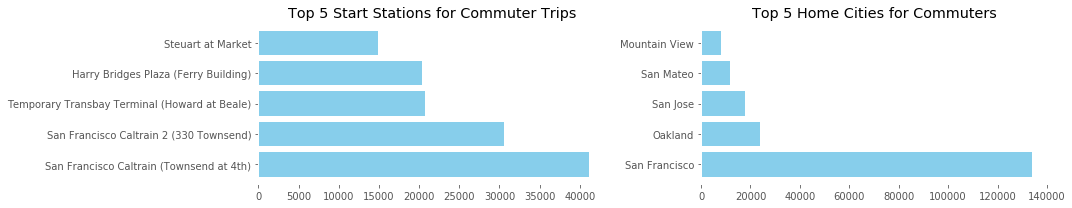

In [53]:
fig12 = plt.figure(figsize=(15,3))
plt.subplot(121, facecolor='white')
plt.title("Top 5 Start Stations for Commuter Trips")
plt.barh(df_comm_trips_stns.start_station_name, df_comm_trips_stns.rec_ct, color='skyblue')

plt.subplot(122, facecolor='white')
plt.title("Top 5 Home Cities for Commuters")
plt.barh(df_comm_trips_city.zip_city, df_comm_trips_city.rec_ct, color='skyblue')

plt.tight_layout()
plt.show()

### Recommendations

- During EDA, we found that the number of trips are much lesser during weekends. Offers with special weekend rates for customers may help increase ridership during weekends
- We also noticed that the number of trips for subscribers and customers are very close on weekends. Special offers with discounts for popular shops, restaurants have help increase subscriber ridership during weekends
- The ridership is also lesser during the first and last two months of the year. This may be due to the cold weather in these months. Special pricing along with discounts for hot beverages (coffee shops etc.) may help increase ridership in these months.
- We also found peak usage during certain hours of the day. Offers for off peak hours may also help increase ridership.
- Our EDA also highlighted customers whose home state is California and home cities are close to San Francisco. Offers and promotions motivating such customers to become subscribers (such as free rides for the first month) may also help.
- We also saw that there are trips related customers from a majority of states outside of California. These are probably the trips related to tourists visiting California. They may be looking for a monthly or a weekly subscription model depending on the duration of their stay in California.
- We also noticed that most of the trips have short durations and the duration for the majority of the trips is less than an hour. This indicates that the current program is mostly attracting commuters an customers who use bike for short distances. There may be an opportunity to attract recreational bikers who bike for longer distances and hence longer durations. Such offers may in fact be combined with the weekend offers as most of the recreational bikers go biking on weekends. 
- In addition, a lot of recreational bikers also bike after work hours. Based on our EDA we know that the number of trips starting in evenings and nights is generally very low for both subscribers and customers. Offers allowing bikers to rent bikes for longer durations at attractive prices in evenings and nights may also help.
- The EDA of the bikeshare station status data highlighted some stations where the utilization is really low at various time periods. It may be worthwhile to look into certain station specific offers for these stations as well.

### Conclusion

While bikeshare appears to be gaining popularity among commuters, a lot can still be done to increase rideship among other categories of people including but not limited to tourists and recreational bikers. There are also opportunities for increasing the outreach to subscribers through offers that motivate them to use the bikes for purpose other than work commutes. There are also opportunities to look into other external factors that may be impacting the usage of bikes in the stations with low utilization. We also noticed that very few stations have had new docks installed of late. There may be opportunities to increase ridership in the popular stations as well by increasing the number of docks. The opportunities can be leveraged to attract not only local subscribers and customers but also from outside California. In short, bikeshares have huge potential for growth.

### Appendix

#### Intermediate Dataset Queries

- bikeshare_status_details
```
#standardSQL
SELECT station_id, bikes_available,docks_available, 
FORMAT_DATETIME("%x",DATETIME(time)) as clndr_date,
FORMAT_DATETIME("%X",DATETIME(time)) as time_of_day,
FORMAT_DATETIME("%Y",DATETIME(time)) as clndr_year,
FORMAT_DATETIME("%b",DATETIME(time)) as clndr_month,
FORMAT_DATETIME("%m",DATETIME(time)) as clndr_month_num,
FORMAT_DATETIME("%d",DATETIME(time)) as clndr_day_num,
FORMAT_DATETIME("%a",DATETIME(time)) as clndr_day_of_week,
FORMAT_DATETIME("%H",DATETIME(time)) as hour_of_day
FROM `bigquery-public-data.san_francisco.bikeshare_status`
```

- bikeshare_sts_mth_summary 
```
#standardSQL
SELECT station_id, clndr_month, clndr_month_num,
max(bikes_available) as max_bikes_available, 
min(bikes_available) as min_bikes_available,
max(docks_available) as max_docks_available, 
min(docks_available) as min_docks_available,
max(bikes_available + docks_available) as total_bikes,
round(100 * if (max(bikes_available + docks_available) > 0, 
min(bikes_available)/max(bikes_available + docks_available), 0),2) as unused_pct
FROM `strange-song-215316.bike_trip_data.bikeshare_status_details` 
group by station_id, clndr_month, clndr_month_num order by 1,3
```

- bikeshare_sts_day_summary 
```
#standardSQL
SELECT station_id, clndr_day_num,
max(bikes_available) as max_bikes_available, 
min(bikes_available) as min_bikes_available,
max(docks_available) as max_docks_available, 
min(docks_available) as min_docks_available,
max(bikes_available + docks_available) as total_bikes,
round(100 * if (max(bikes_available + docks_available) > 0, 
min(bikes_available)/max(bikes_available + docks_available), 0),2) as unused_pct
FROM `strange-song-215316.bike_trip_data.bikeshare_status_details` 
group by station_id, clndr_day_num order by 1,2
```

- bikeshare_sts_weekday_summary 
```
#standardSQL
SELECT station_id, clndr_day_of_week,
max(bikes_available) as max_bikes_available, 
min(bikes_available) as min_bikes_available,
max(docks_available) as max_docks_available, 
min(docks_available) as min_docks_available,
max(bikes_available + docks_available) as total_bikes,
round(100 * if (max(bikes_available + docks_available) > 0, 
min(bikes_available)/max(bikes_available + docks_available), 0),2) as unused_pct
FROM `strange-song-215316.bike_trip_data.bikeshare_status_details` 
group by station_id, clndr_day_of_week
```

- bikeshare_sts_hour_summary 
```
#standardSQL
SELECT station_id, hour_of_day,
max(bikes_available) as max_bikes_available, 
min(bikes_available) as min_bikes_available,
max(docks_available) as max_docks_available, 
min(docks_available) as min_docks_available,
max(bikes_available + docks_available) as total_bikes,
round(100 * if (max(bikes_available + docks_available) > 0, 
min(bikes_available)/max(bikes_available + docks_available), 0),2) as unused_pct
FROM `strange-song-215316.bike_trip_data.bikeshare_status_details` 
group by station_id, hour_of_day order by 1,2
```

- bikeshare_trip_details
```
#standardSQL
SELECT  trip_id, duration_sec, start_date as start_datetime, start_station_name, start_station_id,
end_date as end_datetime, end_station_name, end_station_id, bike_number, zip_code,subscriber_type,
FORMAT_DATETIME("%x",DATETIME(start_date)) as start_date,
FORMAT_DATETIME("%X",DATETIME(start_date)) as start_time,
FORMAT_DATETIME("%Y",DATETIME(start_date)) as trip_year,
FORMAT_DATETIME("%b",DATETIME(start_date)) as trip_month,
FORMAT_DATETIME("%m",DATETIME(start_date)) as trip_month_num,
FORMAT_DATETIME("%d",DATETIME(start_date)) as trip_day_num,
FORMAT_DATETIME("%a",DATETIME(start_date)) as trip_day_of_week,
FORMAT_DATETIME("%H",DATETIME(start_date)) as trip_hour,
FORMAT_DATETIME("%x",DATETIME(end_date)) as end_date,
FORMAT_DATETIME("%X",DATETIME(end_date)) as end_time,
case when start_station_name=end_station_name then 'RoundTrip' else 'OneWayTrip' end as trip_type,
case when cast(format_datetime("%H",datetime(start_date)) as int64) between 0 and 2 then "Night"  
when cast(format_datetime("%H",datetime(start_date)) as int64) between 2 and 5 then "Early Morning"  
when cast(format_datetime("%H",datetime(start_date)) as int64) between 5 and 12 then "Morning"    
when cast(format_datetime("%H",datetime(start_date)) as int64) between 12 and 17 then "Afternoon"
when cast(format_datetime("%H",datetime(start_date)) as int64) between 17 and 22 then "Evening"
when cast(format_datetime("%H",datetime(start_date)) as int64) between 22 and 24 then "Night"end as trip_time
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
```